### Table of Contents

* [Initial Configurations](#IC)
    * [Import Libraries](#IL)
    * [Autheticate the AML Workspace](#AML)
* [Get Data (Bronze)](#GD)
    * [Setup Directory Structure](#SD)
    * [Check the uploaded files](#UF)
    * [Read the movies data](#MD)
    * [Features](#F)    
* [Data Wrangling](#DW)
    * [Step1. Remove unwanted features](#S1)
    * [Step2. Remove features which has too many missing values or is insignificant](#S2)
    * [Step3. Remove rows based on value of certain features](#S3)
    * [Step4. Fix column types](#S4)
    * [Step5. Handle null values](#S5)
    * [Step6. Remove duplicates](#S6)
    * [Step7. Fix casing](#S7)
    * [Step8. Text data clean (NLP): Clean up the overview attribute and add another column 'overview_cleaned'](#S8)   
    * [Step9. Identify outliers and bad data](#S9)
* [Put Data (Silver)](#PS)
    * [Write the transformed dataframe to the silver zone](#WS)
    * [Read silver zone movies file](#RS)

### Initial Configurations <a class="anchor" id="IC"></a>

#### Import Libraries <a class="anchor" id="IL"></a>

In [2]:
#Import required Libraries
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import azureml.core
import azureml.automl
#from azureml.core.experiment import Experiment
from azureml.core import Workspace, Dataset, Datastore

#### Autheticate the AML Workspace <a class="anchor" id="AML"></a>

In [3]:
#Autheticate the AML Workspace
workspace = Workspace.from_config()
output = {}
output['Subscription ID'] = workspace.subscription_id
output['Workspace Name'] = workspace.name
output['Resource Group'] = workspace.resource_group
output['Location'] = workspace.location
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,REDACTED
Workspace Name,REDACTED
Resource Group,calcutta_demos
Location,eastus2


### Get Data (Bronze) <a class="anchor" id="GD"></a>
- Raw data extraction for the file, API based and web datasets. Let us call this __Bronze Layer__.
- Data transformation using python from Raw to Processed stage. We will call this __Silver Layer__.
- Finally store the processed data using standard taxonomy in a SQL based serving layer. We will call this __Gold Layer__.

#### Setup Directory Structure <a class="anchor" id="SD"></a>

In [4]:
data_folder = os.path.join(os.getcwd(), 'data')
#'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data'

#Create the data directory
os.makedirs(data_folder, exist_ok=True)

#Create the bronze, silver and gold folders
bronze_data_folder = data_folder +"/bronze"
os.makedirs(bronze_data_folder, exist_ok=True)

silver_data_folder = data_folder +"/silver"
os.makedirs(silver_data_folder, exist_ok=True)

gold_data_folder = data_folder +"/gold"
os.makedirs(gold_data_folder, exist_ok=True)


#Create sub folder
#'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file'
file_data_bronze = bronze_data_folder +"/flat_file"
os.makedirs(file_data_bronze, exist_ok=True)

#Manually upload the folders from Kaggle

In [5]:
file_data_bronze

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file'

#### Check the uploaded files <a class="anchor" id="UF"></a>

In [6]:
#List the folder structure and the files
for root, directories, files in os.walk(file_data_bronze, topdown=True):
	for name in directories:
		print(os.path.join(root, name))    
	for name in files:
		print(os.path.join(root, name))

/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/credits.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/keywords.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/links.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/links_small.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/movies_metadata.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/ratings.csv
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bro

#### Read the movies data <a class="anchor" id="MD"></a>

In [8]:
#Read the movies_metadata csv
# The main Movies Metadata file. Contains information on 45,000 movies featured in 
#  the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, 
#   languages, production countries and companies. Some of the columns of this file are nested JSON objects.

movies_metadata_file = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/bronze/flat_file/movies_metadata.csv'
df_movies_metadata_bronze = pd.read_csv(movies_metadata_file)
df_movies_metadata_bronze.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycMJ9pSAn204.jpg', 'backdrop_path': '/7qwE57OVZmMJChBpLEbJEmzUydk.jpg'}",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,False,5.7,173.0


In [9]:
#Number of rows and columns
df_movies_metadata_bronze.shape

(45466, 24)

In [10]:
#It is easier to view the data if we transpose
df_movies_metadata_bronze.head(3).transpose()


,0,1,2
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}"
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]","[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]","[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN
id,862,8844,15602
imdb_id,tt0114709,tt0113497,tt0113228
original_language,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men
overview,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.","When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.","A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max."


In [11]:
#List of columns
df_movies_metadata_bronze.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

#### Features <a class="anchor" id="F"></a>
- __adult:__ Indicates if the movie is X-Rated or Adult.
- __belongs_to_collection:__ A stringified dictionary that gives information on the movie series the particular film belongs to.
- __budget:__ The budget of the movie in dollars.
- __genres:__ A stringified list of dictionaries that list out all the genres associated with the movie.
- __homepage:__ The Official Homepage of the move.
- __id:__ The ID of the move.
- __imdb_id:__ The IMDB ID of the movie.
- __original_language:__ The language in which the movie was originally shot in.
- __original_title:__ The original title of the movie.
- __overview:__ A brief blurb of the movie.
- __popularity:__ The Popularity Score assigned by TMDB.
- __poster_path:__ The URL of the poster image.
- __production_companies:__ A stringified list of production companies involved with the making of the movie.
- __production_countries:__ A stringified list of countries where the movie was shot/produced in.
- __release_date:__ Theatrical Release Date of the movie.
- __revenue:__ The total revenue of the movie in dollars.
- __runtime:__ The runtime of the movie in minutes.
- __spoken_languages:__ A stringified list of spoken languages in the film.
- __status:__ The status of the movie (Released, To Be Released, Announced, etc.)
tagline:__ The tagline of the movie.
- __title:__ The Official Title of the movie.
- __video:__ Indicates if there is a video present of the movie with TMDB.
- __vote_average:__ The average rating of the movie.
- __vote_count:__ The number of votes by users, as counted by TMDB.

In [12]:
df_movies_metadata_bronze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

As we can see there are a total of 45,466 movies with 24 features and most of the features have very few NaN values.
Next we will start cleaning up the data.

### Data Wrangling <a class="anchor" id="DW"></a>

#### Step1.  Remove unwanted features  <a class="anchor" id="S1"></a>

- __imdb_id__ Since we only need the tmdb id to call the api
- __original_title__ Since we have the offical title of the movie in the column title
- __belongs_to_collection__ We do not have use for this in the context of this analysis
- __poster_path__ We do not have use for this in the context of this analysis
- __video__ We do not have use for this in the context of this analysis
- __homepage__ We do not have use for this in the context of this analysis
- __tagline__ We do not have use for this in the context of this analysis

In [13]:
#Removed the unwanted features
df_movies_metadata_bronze.drop(['imdb_id', 'original_title' ,'belongs_to_collection', 'poster_path' ,'video', 'homepage' ,'tagline'], axis=1, inplace=True)

In [14]:
#List of columns
df_movies_metadata_bronze.columns

Index(['adult', 'budget', 'genres', 'id', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'title', 'vote_average', 'vote_count'],
      dtype='object')

#### Step2.  Remove features which has too many missing values or values of one type for it to contribute anything meaningful <a class="anchor" id="S2"></a>

In [15]:
#lets find the unique values in a column to get a starting point
# We can safely ignore the columns whihc has lot of unique values
df_movies_metadata_bronze.nunique(axis=0)

adult                   5    
budget                  1226 
genres                  4069 
id                      45436
original_language       92   
overview                44307
popularity              44176
production_companies    22708
production_countries    2393 
release_date            17336
revenue                 6863 
runtime                 353  
spoken_languages        1931 
status                  6    
title                   42277
vote_average            92   
vote_count              1820 
dtype: int64

So we got the following columns to inspect
- adult
- status
- vote_average
- original_language

In [16]:
df_movies_metadata_bronze['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                              9    
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                    1    
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.    1    
 - Written by Ørnås                                                                                                               1    
Name: adult, dtype: int64

In [17]:
df_movies_metadata_bronze['status'].value_counts()

Released           45014
Rumored            230  
Post Production    98   
In Production      20   
Planned            15   
Canceled           2    
Name: status, dtype: int64

In [18]:
df_movies_metadata_bronze['vote_average'].value_counts()

0.0    2998
6.0    2468
5.0    2001
7.0    1886
6.5    1722
       ... 
9.4    3   
9.8    1   
0.7    1   
9.6    1   
1.1    1   
Name: vote_average, Length: 92, dtype: int64

In [19]:
df_movies_metadata_bronze['original_language'].value_counts()

en      32269
fr      2438 
it      1529 
ja      1350 
de      1080 
        ...  
82.0    1    
rw      1    
si      1    
zu      1    
tg      1    
Name: original_language, Length: 92, dtype: int64

- Since we have just 9 adult movies in the dataset, we can safely drop them from the analysis

In [20]:
#Removed the insignificant features
df_movies_metadata_bronze.drop(['adult'], axis=1, inplace=True)

In [21]:
df_movies_metadata_bronze.columns

Index(['budget', 'genres', 'id', 'original_language', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title',
       'vote_average', 'vote_count'],
      dtype='object')

#### Step3.  Remove rows based on value of certain features <a class="anchor" id="S3"></a>

In [22]:
df_movies_metadata_bronze['status'].value_counts()

Released           45014
Rumored            230  
Post Production    98   
In Production      20   
Planned            15   
Canceled           2    
Name: status, dtype: int64

For our analysis we can safely remove the movies in the following status
- Rumored            230   
- Planned            15   
- Canceled           2   

In [23]:
#Get the omit values in a list and then filter
omit_values_list = ['Rumored','Planned','Canceled']
df_movies_metadata_bronze = df_movies_metadata_bronze[~df_movies_metadata_bronze.status.isin(omit_values_list)]

In [24]:
df_movies_metadata_bronze['status'].value_counts()

Released           45014
Post Production    98   
In Production      20   
Name: status, dtype: int64

In [25]:
#df_movies_metadata_bronze['popularity'].value_counts()

##?? Can we remove the movies which are not popular?

#### Step4.  Fix column types <a class="anchor" id="S4"></a>

In [26]:
df_movies_metadata_bronze.dtypes

budget                  object 
genres                  object 
id                      object 
original_language       object 
overview                object 
popularity              object 
production_companies    object 
production_countries    object 
release_date            object 
revenue                 float64
runtime                 float64
spoken_languages        object 
status                  object 
title                   object 
vote_average            float64
vote_count              float64
dtype: object

In [27]:
#https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html?highlight=to_numeric#pandas.to_numeric
#If errors='coerce', then invalid parsing will be set as NaN.
print (df_movies_metadata_bronze[pd.to_numeric(df_movies_metadata_bronze['id'], errors='coerce').isnull()])

                                 budget  \
19730  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                                                                                                                                                                                genres  \
19730  [{'name': 'Carousel Productions', 'id': 11176}, {'name': 'Vision View Entertainment', 'id': 11602}, {'name': 'Telescene Film Group Productions', 'id': 29812}]                                                    
29503  [{'name': 'Aniplex', 'id': 2883}, {'name': 'GoHands', 'id': 7759}, {'name': 'BROSTA TV', 'id': 7760}, {'name': 'Mardock Scramble Production Committee', 'id': 7761}, {'name': 'Sentai Filmworks', 'id': 33751}]   
35587  [{'name': 'Odyssey Media', 'id': 17161}, {'name': 'Pulser Productions', 'id': 18012}, {'name': 'Rogue State', 'id': 18013}, {'name': 'The Cartel', 'id': 23822}]      

We have just 3 rows where the id column is not numeric. So we will drop it and convert the rest to numeric.

In [28]:
#downcast{‘integer’, ‘signed’, ‘unsigned’, ‘float’}, default None
#If not None, and if the data has been successfully cast to a numerical dtype (or if the data was numeric to begin with), downcast that resulting data to the smallest numerical dtype possible according to the following rules:
#‘integer’ or ‘signed’: smallest signed int dtype (min.: np.int8)
#‘unsigned’: smallest unsigned int dtype (min.: np.uint8)
#‘float’: smallest float dtype (min.: np.float32)

df_movies_metadata_bronze["id"] =pd.to_numeric(df_movies_metadata_bronze['id'], errors='coerce',downcast="integer")
df_movies_metadata_bronze.dropna(subset=["id"],inplace=True)

In [29]:
print (df_movies_metadata_bronze[pd.to_numeric(df_movies_metadata_bronze['id'], errors='coerce').isnull()])

Empty DataFrame
Columns: [budget, genres, id, original_language, overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, title, vote_average, vote_count]
Index: []


In [30]:
#We have just 3 rows where the popularity column is not numeric. So we will drop it and convert the rest to numeric.
print (df_movies_metadata_bronze[pd.to_numeric(df_movies_metadata_bronze['popularity'], errors='coerce').isnull()])

      budget  \
19729  0       
29502  0       
35586  0       

                                                                                                                                        genres  \
19729  [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]                                               
29502  [{'id': 16, 'name': 'Animation'}, {'id': 878, 'name': 'Science Fiction'}]                                                                 
35586  [{'id': 10770, 'name': 'TV Movie'}, {'id': 28, 'name': 'Action'}, {'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]   

             id original_language  \
19729  82663.0   en                 
29502  122662.0  ja                 
35586  249260.0  en                 

                                                                                                                                                                                                         

In [31]:
df_movies_metadata_bronze["popularity"] =pd.to_numeric(df_movies_metadata_bronze['popularity'], errors='coerce',downcast="integer")
df_movies_metadata_bronze.dropna(subset=["popularity"],inplace=True)

In [32]:
print (df_movies_metadata_bronze[pd.to_numeric(df_movies_metadata_bronze['popularity'], errors='coerce').isnull()])

Empty DataFrame
Columns: [budget, genres, id, original_language, overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, title, vote_average, vote_count]
Index: []


In [33]:
#Budget column should be numeric and there is no rows that are in opposition
print (df_movies_metadata_bronze[pd.to_numeric(df_movies_metadata_bronze['budget'], errors='coerce').isnull()])

Empty DataFrame
Columns: [budget, genres, id, original_language, overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, title, vote_average, vote_count]
Index: []


In [34]:
df_movies_metadata_bronze["budget"] =pd.to_numeric(df_movies_metadata_bronze['budget'], errors='coerce',downcast="integer")
df_movies_metadata_bronze.dropna(subset=["budget"],inplace=True)

In [40]:
df_movies_metadata_bronze['original_language'] = pd.Series(df_movies_metadata_bronze['original_language'], dtype="string")

In [42]:
df_movies_metadata_bronze.dtypes

budget                  int32  
genres                  object 
id                      float64
original_language       string 
overview                object 
popularity              float64
production_companies    object 
production_countries    object 
release_date            object 
revenue                 float64
runtime                 float64
spoken_languages        object 
status                  object 
title                   object 
vote_average            float64
vote_count              float64
dtype: object

While we are tried to do our best, the latest release of Pandas has a function called convert_dtypes which Convert columns to best possible dtypes using dtypes supporting pd.NA.
Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.convert_dtypes.html

In [48]:
#pip install --upgrade pandas
pd. __version__

'1.1.5'

In [46]:
 df_movies_metadata_bronze = df_movies_metadata_bronze.convert_dtypes()

In [47]:
df_movies_metadata_bronze.dtypes

budget                  Int32  
genres                  string 
id                      Int64  
original_language       string 
overview                string 
popularity              float64
production_companies    string 
production_countries    string 
release_date            string 
revenue                 Int64  
runtime                 Int64  
spoken_languages        string 
status                  string 
title                   string 
vote_average            float64
vote_count              Int64  
dtype: object

#### Step5.  Handle null values <a class="anchor" id="S5"></a>

In [49]:
df_movies_metadata_bronze.isnull().sum()

budget                  0  
genres                  0  
id                      0  
original_language       10 
overview                940
popularity              0  
production_companies    0  
production_countries    0  
release_date            81 
revenue                 0  
runtime                 257
spoken_languages        0  
status                  81 
title                   0  
vote_average            0  
vote_count              0  
dtype: int64

original_language, release_date and status (released or not) is important. So we will remove those rows from our datset.
Obviosuly we will  quickly inspected it row by row but since they are so low in number we will eventually remove it unless something is striking.

In [52]:
df_movies_metadata_bronze[df_movies_metadata_bronze.original_language.isnull()]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
19574,0,"[{'id': 99, 'name': 'Documentary'}]",283101,<NA>,Documentary about the production of The Third Man (1949).,0.017007,"[{'name': 'StudioCanal', 'id': 694}, {'name': 'British Broadcasting Corporation (BBC)', 'id': 3324}, {'name': 'Österreichischer Rundfunk (ORF)', 'id': 3391}, {'name': 'Turner Classic Movies (TCM)', 'id': 10915}, {'name': 'NHK', 'id': 15505}, {'name': 'Media Europa', 'id': 72703}, {'name': 'Silverapples Media', 'id': 72704}]","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'iso_3166_1': 'FR', 'name': 'France'}, {'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]",2004-10-11,0,95,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso_639_1': 'en', 'name': 'English'}]",Released,Shadowing the Third Man,0.0,0
21602,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}]",103902,<NA>,An Outback farmer takes in an Afghani woman who has fled from a brothel.,0.359818,"[{'name': 'New Holland Pictures', 'id': 10229}, {'name': 'IDTV Film', 'id': 12022}]","[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2007-08-04,0,94,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Unfinished Sky,6.4,8
22832,0,"[{'id': 10752, 'name': 'War'}, {'id': 37, 'name': 'Western'}]",359195,<NA>,A group of Union Army soldiers is charged with protecting a box of gold and getting it to its rightful place within the government coffers.,0.070647,"[{'name': 'Associated Producers (API)', 'id': 4141}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1960-03-31,0,69,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,13 Fighting Men,0.0,0
32141,0,"[{'id': 35, 'name': 'Comedy'}]",147050,<NA>,"George and Gracie enter an elegant drawing room, looking everywhere for something. Turns out, they're looking for the audience, and when George spots the camera, they start in on their patter. Gracie wants to convince George that she's smart, not dizzy - it's an uphill struggle of which she's blissfully unaware. Midway through, they break into song: ""Do You Believe Me?"" It includes a little bit of hoofing as the chatting continues. They end on a story Gracie whispers into George's ear.",0.073418,"[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'The Vitaphone Corporation', 'id': 9329}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1929-10-31,0,8,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Lambchops,6.5,2
37407,0,"[{'id': 16, 'name': 'Animation'}]",257095,<NA>,The first fairy tale transformed into a full-length picture by Jiri Trnka. It is based on the charming story about prince Bajaja by Bozena Nemcova. Bajaja saves three princesses from a dragon’s claws and then marries the youngest of them.,0.036841,"[{'name': 'Ceskoslovenský Státní Film', 'id': 2502}]","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'}]",1950-01-26,0,87,"[{'iso_639_1': 'cs', 'name': 'Český'}]",Released,Prince Bayaya,5.0,1
41047,0,"[{'id': 99, 'name': 'Documentary'}]",332742,<NA>,"Until the late 1970s, the Pakistani city of Lahore was world-renowned for its music. Following the Islamization of Pakistan, many artists struggled to continue their life's work. Song of Lahore turns the spotlight on a group of stalwart musicians that kept playing and ultimately attracted listeners from around the world.",0.373688,[],[],2015-11-13,0,82,"[{'iso_639_1': 'ur', 'name': 'اردو'}, {'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'pa', 'name': 'ਪੰਜਾਬੀ'}]",Released,Song of Lahore,6.5,2
41872,0,"[{'id': 99, 'name': 'Documentary'}]",144410,<NA>,"Two dancers perform in succession facing a stationary camera. The first is in a diaphanous skirt, held out by her hands with arms extended. She smiles, wearing butterfly wings on her back and the wings of Mercury in her hair. Her dance emphasizes the movement 

In [70]:
#We will not be removing any popular movie having original_language as null
df_movies_metadata_bronze[df_movies_metadata_bronze.original_language.isnull() & df_movies_metadata_bronze.popularity > 1]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count


In [69]:
#We will not be removing any popular movie having status as null
df_movies_metadata_bronze[df_movies_metadata_bronze.status.isnull() & df_movies_metadata_bronze.popularity > 1] 

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count


In [68]:
#We will not be removing any popular movie having release_date as null
df_movies_metadata_bronze[df_movies_metadata_bronze.release_date.isnull() & df_movies_metadata_bronze.popularity > 1]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count


In [130]:
df_movies_metadata_bronze.dropna(subset=["original_language","status","release_date","runtime"],inplace=True)

In [120]:
#Lets fill the NAs with an empty string '' for overview attribute
df_movies_metadata_bronze[['overview']] = df_movies_metadata_bronze[['overview']].fillna(value='')

In [129]:
#We will not be removing any popular movie having runtime as null
df_movies_metadata_bronze[df_movies_metadata_bronze.runtime.isnull() & df_movies_metadata_bronze.popularity > 1]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,overview_cleaned


In [131]:
#Checking and there are no null values in the dataset
df_movies_metadata_bronze.isnull().sum()

budget                  0
genres                  0
id                      0
original_language       0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
overview_cleaned        0
dtype: int64

#### Step6.  Remove duplicates <a class="anchor" id="S6"></a>

In [78]:
#Duplicate rows
df_movies_metadata_bronze[df_movies_metadata_bronze.duplicated()].head()

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
1465,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",105045,de,"East-Berlin, 1961, shortly after the erection of the Wall. Konrad, Sophie and three of their friends plan a daring escape to Western Germany. The attempt is successful, except for Konrad, who remains behind. From then on, and for the next 28 years, Konrad and Sophie will attempt to meet again, in spite of the Iron Curtain. Konrad, who has become a reputed Astrophysicist, tries to take advantage of scientific congresses outside Eastern Germany to arrange encounters with Sophie. But in a country where the political police, the Stasi, monitors the moves of all suspicious people (such as Konrad's sister Barbara and her husband Harald), preserving one's privacy, ideals and self-respect becomes an exhausting fight, even as the Eastern block begins its long process of disintegration.",0.122178,"[{'name': 'Studio Babelsberg', 'id': 264}, {'name': 'Centre National de la Cinématographie', 'id': 310}, {'name': 'Odessa Films', 'id': 1712}, {'name': 'Canal+', 'id': 5358}, {'name': 'Bioskop Film', 'id': 5982}, {'name': 'Westdeutscher Rundfunk (WDR)', 'id': 7025}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1995-02-16,0,115,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,The Promise,5.0,1
9165,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]",5511,fr,Hitman Jef Costello is a perfectionist who always carefully plans his murders and who never gets caught.,9.091288,"[{'name': 'Fida cinematografica', 'id': 73}, {'name': 'Compagnie Industrielle et Commerciale Cinématographique (CICC)', 'id': 11788}, {'name': 'TC Productions', 'id': 21777}, {'name': 'Filmel', 'id': 42182}]","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso_3166_1': 'IT', 'name': 'Italy'}]",1967-10-25,39481,105,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,Le Samouraï,7.9,187
9327,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 18, 'name': 'Drama'}, {'id': 28, 'name': 'Action'}, {'id': 10769, 'name': 'Foreign'}]",23305,en,"In feudal India, a warrior (Khan) who renounces his role as the longtime enforcer to a local lord becomes the prey in a murderous hunt through the Himalayan mountains.",1.967992,"[{'name': 'Filmfour', 'id': 6705}]","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'IN', 'name': 'India'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2001-09-23,0,86,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,The Warrior,6.3,15
13375,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, 'name': 'Mystery'}]",141971,fi,"Recovering from a nail gun shot to the head and 13 months of coma, doctor Pekka Valinta starts to unravel the mystery of his past, still suffering from total amnesia.",0.411949,"[{'name': 'Filmiteollisuus Fine', 'id': 5166}]","[{'iso_3166_1': 'FI', 'name': 'Finland'}]",2008-12-26,0,108,"[{'iso_639_1': 'fi', 'name': 'suomi'}]",Released,Blackout,6.7,3
16764,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, 'name': 'Mystery'}]",141971,fi,"Recovering from a nail gun shot to the head and 13 months of coma, doctor Pekka Valinta starts to unravel the mystery of his past, still suffering from total amnesia.",0.411949,"[{'name': 'Filmiteollisuus Fine', 'id': 5166}]","[{'iso_3166_1': 'FI', 'name': 'Finland'}]",2008-12-26,0,108,"[{'iso_639_1': 'fi', 'name': 'suomi'}]",Released,Blackout,6.7,3


In [77]:
df_movies_metadata_bronze[df_movies_metadata_bronze.id==105045]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
676,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",105045,de,"East-Berlin, 1961, shortly after the erection of the Wall. Konrad, Sophie and three of their friends plan a daring escape to Western Germany. The attempt is successful, except for Konrad, who remains behind. From then on, and for the next 28 years, Konrad and Sophie will attempt to meet again, in spite of the Iron Curtain. Konrad, who has become a reputed Astrophysicist, tries to take advantage of scientific congresses outside Eastern Germany to arrange encounters with Sophie. But in a country where the political police, the Stasi, monitors the moves of all suspicious people (such as Konrad's sister Barbara and her husband Harald), preserving one's privacy, ideals and self-respect becomes an exhausting fight, even as the Eastern block begins its long process of disintegration.",0.122178,"[{'name': 'Studio Babelsberg', 'id': 264}, {'name': 'Centre National de la Cinématographie', 'id': 310}, {'name': 'Odessa Films', 'id': 1712}, {'name': 'Canal+', 'id': 5358}, {'name': 'Bioskop Film', 'id': 5982}, {'name': 'Westdeutscher Rundfunk (WDR)', 'id': 7025}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1995-02-16,0,115,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,The Promise,5.0,1
1465,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",105045,de,"East-Berlin, 1961, shortly after the erection of the Wall. Konrad, Sophie and three of their friends plan a daring escape to Western Germany. The attempt is successful, except for Konrad, who remains behind. From then on, and for the next 28 years, Konrad and Sophie will attempt to meet again, in spite of the Iron Curtain. Konrad, who has become a reputed Astrophysicist, tries to take advantage of scientific congresses outside Eastern Germany to arrange encounters with Sophie. But in a country where the political police, the Stasi, monitors the moves of all suspicious people (such as Konrad's sister Barbara and her husband Harald), preserving one's privacy, ideals and self-respect becomes an exhausting fight, even as the Eastern block begins its long process of disintegration.",0.122178,"[{'name': 'Studio Babelsberg', 'id': 264}, {'name': 'Centre National de la Cinématographie', 'id': 310}, {'name': 'Odessa Films', 'id': 1712}, {'name': 'Canal+', 'id': 5358}, {'name': 'Bioskop Film', 'id': 5982}, {'name': 'Westdeutscher Rundfunk (WDR)', 'id': 7025}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1995-02-16,0,115,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,The Promise,5.0,1


As a matter of fact we found a few duplicate rows.

In [80]:
df_movies_metadata_bronze.shape

(45042, 16)

In [81]:
df_movies_metadata_bronze.drop_duplicates(inplace=True)

In [82]:
df_movies_metadata_bronze.shape

(45026, 16)

In [87]:
#To become certain I would like to check the duplicate again but on id field since it acts as a primary key
df_movies_metadata_bronze[df_movies_metadata_bronze.duplicated(subset=['id'])].head()

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
12066,1600000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}, {'id': 9648, 'name': 'Mystery'}]",14788,en,"Set against the backdrop of a decaying Midwestern town, a murder becomes the focal point of three people who work in a doll factory.",3.008299,"[{'name': 'Magnolia Pictures', 'id': 1030}, {'name': 'Extension 765', 'id': 8850}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2005-09-03,0,73,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Bubble,6.4,36
15074,4,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}, {'id': 10752, 'name': 'War'}]",22649,en,"British nurse Catherine Barkley (Helen Hayes) and American Lieutenant Frederic Henry (Gary Cooper) fall in love during the First World War in Italy. Eventually separated by Frederic's transfer, tremendous challenges and difficult decisions face each, as the war rages on. Academy Awards winner for Best Cinematography and for Best Sound, Recording. Nominated for Best Picture and for Best Art Direction.",2.411191,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1932-12-08,25,89,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Farewell to Arms,6.2,29
15765,2500,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 10769, 'name': 'Foreign'}]",13209,fa,"Since women are banned from soccer matches, Iranian females masquerade as males so they can slip into Tehran's stadium to see the game between Iran and Bahrain. The ones who are caught and arrested are taken to a holding area and guarded by soldiers. One sympathetic soldier agrees to watch the game through a peephole and recount the action to the impatient fans.",1.529879,"[{'name': 'Jafar Panahi Film Productions', 'id': 2835}]","[{'iso_3166_1': 'IR', 'name': 'Iran'}]",2006-05-26,0,93,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Offside,6.7,27
20843,40000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, 'name': 'Drama'}]",77221,en,"On the Arabian Peninsula in the 1930s, two warring leaders come face to face. The victorious Nesib, Emir of Hobeika, lays down his peace terms to rival Amar, Sultan of Salmaah. The two men agree that neither can lay claim to the area of no man’s land between them called The Yellow Belt. In return, Nesib adopts Amar’s two boys Saleeh and Auda as a guarantee against invasion. Twelve years later, Saleeh and Auda have grown into young men. Saleeh, the warrior, itches to escape his gilded cage and return to his father’s land. Auda cares only for books and the pursuit of knowledge. One day, their adopted father Nesib is visited by an American from Texas. He tells the Emir that his land is blessed with oil and promises him riches beyond his wildest imagination. Nesib imagines a realm of infinite possibility, a kingdom with roads, schools and hospitals all paid for by the black gold beneath the barren sand. There is only one problem. The precious oil is located in the Yellow Belt.",6.475665,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name': 'Quinta Communications', 'id': 6370}, {'name': 'Carthago Films S.a.r.l.', 'id': 20395}, {'name': 'Prima TV', 'id': 60229}, {'name': 'Doha Film Institute, The', 'id': 72917}]","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_3166_1': 'QA', 'name': 'Qatar'}, {'iso_3166_1': 'TN', 'name': 'Tunisia'}]",2011-12-21,5446000,130,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Black Gold,5.9,77
20899,0,"[{'id': 18, 'name': 'Drama'}]",109962,en,"Two literary women compete for 20 years: one writes for the critics; the other one, to get rich.",10.396878,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}, {'name': 'Jaquet', 'id': 16778}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1981-09-23,0,115,"[{'iso_639_1': 'en', 'name': 'English

In [88]:
df_movies_metadata_bronze[df_movies_metadata_bronze.duplicated(subset=['id'])].count()

budget                  13
genres                  13
id                      13
original_language       13
overview                13
popularity              13
production_companies    13
production_countries    13
release_date            13
revenue                 13
runtime                 13
spoken_languages        13
status                  13
title                   13
vote_average            13
vote_count              13
dtype: int64

In [89]:
df_movies_metadata_bronze[df_movies_metadata_bronze.id==14788]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
10419,1600000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}, {'id': 9648, 'name': 'Mystery'}]",14788,en,"Set against the backdrop of a decaying Midwestern town, a murder becomes the focal point of three people who work in a doll factory.",3.185256,"[{'name': 'Magnolia Pictures', 'id': 1030}, {'name': 'Extension 765', 'id': 8850}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2005-09-03,0,73,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Bubble,6.4,36
12066,1600000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}, {'id': 9648, 'name': 'Mystery'}]",14788,en,"Set against the backdrop of a decaying Midwestern town, a murder becomes the focal point of three people who work in a doll factory.",3.008299,"[{'name': 'Magnolia Pictures', 'id': 1030}, {'name': 'Extension 765', 'id': 8850}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2005-09-03,0,73,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Bubble,6.4,36


Indeed we have duplicates on movie id column. We will remove them as well.

In [90]:
df_movies_metadata_bronze.shape

(45026, 16)

In [91]:
#Remove 13 movie id duplicates from the dataset
df_movies_metadata_bronze.drop_duplicates(subset=['id'],inplace=True)

In [92]:
df_movies_metadata_bronze.shape

(45013, 16)

Interestingly different movies can have same title for example the remakes.. So we will have to keep them.

In [93]:
df_movies_metadata_bronze[df_movies_metadata_bronze.duplicated(subset=['title'])].count()

budget                  3105
genres                  3105
id                      3105
original_language       3105
overview                3069
popularity              3105
production_companies    3105
production_countries    3105
release_date            3105
revenue                 3105
runtime                 3098
spoken_languages        3105
status                  3105
title                   3105
vote_average            3105
vote_count              3105
dtype: int64

In [105]:
df_movies_metadata_bronze[df_movies_metadata_bronze.duplicated(subset=['title']) & df_movies_metadata_bronze.popularity > .05].head()

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
888,2238813,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",6620,en,"Linus and David Larrabee are the two sons of a very wealthy family. Linus is all work -- busily running the family corporate empire, he has no time for a wife and family. David is all play -- technically he is employed by the family business, but never shows up for work, spends all his time entertaining, and has been married and divorced three times. Meanwhile, Sabrina Fairchild is the young, shy, and awkward daughter of the household chauffeur, who has been infatuated with David all her life, but David hardly notices her -- ""doesn't even know I exist"" -- until she goes away to Paris for two years, and returns an elegant, sophisticated, beautiful woman. Suddenly, she finds that she has captured David's attention, but just as she does so, she finds herself falling in love with Linus, and she finds that Linus is also falling in love with her.",7.359741,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1954-09-28,10000000,113,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Sabrina,7.4,284
930,0,"[{'id': 18, 'name': 'Drama'}]",85638,en,"In Puritan Boston, seamstress Hester Prynne is punished for playing on the Sabbath day; but kindly minister Arthur Dimmesdale takes pity on her. The two fall in love, but their relationship cannot be: Hester is already married to Roger Prynne, a physician who has been missing seven years. Dimmesdale has to go away to England; when he returns, he finds Hester pregnant with their child, and the focus of the town's censure. In a humiliating public ceremony, she is forced to don the scarlet letter A - for adultery - and wear it the rest of her life.",0.284522,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1926-08-09,0,115,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Scarlet Letter,8.3,4
1296,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]",11349,en,"Sam Bowden witnesses a rape committed by Max Cady and testifies against him. When released after 8 years in prison, Cady begins stalking Bowden and his family but is always clever enough not to violate the law.",7.583191,"[{'name': 'Melville-Talbot Productions', 'id': 11390}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1962-04-12,0,105,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Cape Fear,7.2,125
1644,80000000,"[{'id': 18, 'name': 'Drama'}, {'id': 12, 'name': 'Adventure'}]",9922,en,"In 2013 there are no highways, no I-ways, no dreams of a better tomorrow, only scattered survivors across what was once the Unites States. Into this apocalyptic wasteland comes an enigmatic drifter with a mule, a knack for Shakespeare and something yet undiscovered: the power to inspire hope.",6.537407,"[{'name': 'Tig Productions', 'id': 335}, {'name': 'Warner Bros.', 'id': 6194}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1997-12-25,17626234,177,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,The Postman,6.1,306
1832,750000,"[{'id': 18, 'name': 'Drama'}]",23383,en,"Winner of four Academy Awards, including Best Picture and Best Actor, Sir Laurence Olivier’s Hamlet continues to be the most compelling version of Shakespeare’s beloved tragedy. Olivier is at his most inspired—both as director and as the melancholy Dane himself—as he breathes new life into the words of one of the world’s greatest dramatists.",3.188067,"[{'name': 'Two Cities Films', 'id': 4006}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1948-03-25,0,155,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hamlet,7.1,48


In [107]:
df_movies_metadata_bronze[df_movies_metadata_bronze.title == 'Cape Fear']

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
1295,35000000,"[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name': 'Thriller'}]",1598,en,"Sam Bowden is a small-town corporate attorney. Max Cady is a tattooed, cigar-smoking, bible-quoting, psychotic rapist. What do they have in common? Fourteen years ago, Sam was a public defender assigned to Max Cady's rape trial, and he made a serious error: he hid a document from his illiterate client that could have gotten him acquitted. Now, the cagey, bibliophile Cady has been released, and he intends to teach Sam Bowden and his family a thing or two about loss.",10.302735,"[{'name': 'Universal Pictures', 'id': 33}, {'name': 'Amblin Entertainment', 'id': 56}, {'name': 'Cappa Productions', 'id': 691}, {'name': 'Tribeca Productions', 'id': 11391}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1991-11-15,182300000,128,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Cape Fear,7.0,692
1296,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]",11349,en,"Sam Bowden witnesses a rape committed by Max Cady and testifies against him. When released after 8 years in prison, Cady begins stalking Bowden and his family but is always clever enough not to violate the law.",7.583191,"[{'name': 'Melville-Talbot Productions', 'id': 11390}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1962-04-12,0,105,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Cape Fear,7.2,125


#### Step7.  Fix casing <a class="anchor" id="S7"></a>

In [109]:
#Initcap each word in the title
#test
df_movies_metadata_bronze.title.str.title().head(3)

0    Toy Story       
1    Jumanji         
2    Grumpier Old Men
Name: title, dtype: string

In [110]:
#Initcap each word in the title
#run
df_movies_metadata_bronze['title']  = df_movies_metadata_bronze.title.str.title()

In [111]:
#It is easier to view the data if we transpose
df_movies_metadata_bronze.head(3).transpose()

,0,1,2
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]","[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]","[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"
id,862,8844,15602
original_language,en,en,en
overview,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.","When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.","A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max."
popularity,21.9469,17.0155,11.7129
production_companies,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]"
production_countries,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]"
release_date,1995-10-30,1995-12-15,1995-12-22
revenue,373554033,262797249,0


#### Step8.  Text data clean (NLP): Clean up the overview attribute and add another column 'overview_cleaned' <a class="anchor" id="S8"></a>

In [112]:
#Build punctuation dictionary
import unicodedata
import sys

# Create a dictionary of punctuation characters
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
# Add the backtick/ Grave accent character
punctuation.update({96:None})

In [118]:
#Let us clean up and make the data ready
# As we are going to use words as features so we can use some text formatting techniques which will help us in feature extraction
#  including removing punctuation marks/digits ,and also stop-words. In addition, the implementation of lemmatization words using NLTK
#       Tokenization is the last step to break reviews up into words and other meaningful tokens.

import re 
import string
#pip install nltk
import nltk
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def function_clean_stop(text):
    #convert into lowercase
    text = text.lower()

    #removing the URL Http
    text = re.sub(r"http\S+", "", text) 

    # Removal of mentions
    #text = re.sub("@[^\s]*", "", text) -> Taken care if in the punctuations. But I want to keep the word.

    # Removal of hashtags
    #text = re.sub("#[^\s]*", "", text) -> Taken care if in the punctuations. But I want to keep the word.

    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("'s", "", text)   

    #remove all punctuation from the text.
    text = str(text.translate(punctuation))
    
    listofwords = text.strip().split()          # to remove any space from beginning and the end of text
    tokenized_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            if len(lemm_word)>0:
                tokenized_words.append(lemm_word)
    return_str = ' '.join([str(elem) for elem in tokenized_words])             
    return(return_str)

In [121]:
# applying the cleaning function to text column
df_movies_metadata_bronze['overview_cleaned'] = df_movies_metadata_bronze['overview'].apply(lambda overview: function_clean_stop(overview))

In [123]:
df_movies_metadata_bronze[['overview','overview_cleaned']].head()

,overview,overview_cleaned
0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",led woody andy toy live happily room andy birthday brings buzz lightyear onto scene afraid losing place andy heart woody plot buzz circumstance separate buzz woody owner duo eventually learns put aside difference
1,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",sibling judy peter discover enchanted board game open door magical world unwittingly invite alan adult trapped inside game year living room alan hope freedom finish game prof risky three find running giant rhinoceros evil monkey terrifying creature
2,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",family wedding reignites ancient feud nextdoor neighbor fishing buddy john max meanwhile sultry italian divorcée open restaurant local bait shop alarming local worry shell scare fish away le interested seafood cooking hot time max
3,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",cheated mistreated stepped woman holding breath waiting elusive good man break string lessthanstellar lover friend confidant vannah bernie glo robin talk determined find better way breathe
4,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",george bank recovered daughter wedding receives news pregnant george wife nina expecting planning selling home plan like george change arrival grandchild kid


In [124]:
df_movies_metadata_bronze.dtypes

budget                  Int32  
genres                  string 
id                      Int64  
original_language       string 
overview                string 
popularity              float64
production_companies    string 
production_countries    string 
release_date            string 
revenue                 Int64  
runtime                 Int64  
spoken_languages        string 
status                  string 
title                   string 
vote_average            float64
vote_count              Int64  
overview_cleaned        object 
dtype: object

#### Step9. Identify outliers and bad data <a class="anchor" id="S9"></a>

{'whiskers': [<matplotlib.lines.Line2D at 0x7f911e9b1278>,
 'caps': [<matplotlib.lines.Line2D at 0x7f911e9b1978>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f911e9a3f28>],
 'medians': [<matplotlib.lines.Line2D at 0x7f911e9c50b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f911e9c5438>],
 'means': []}

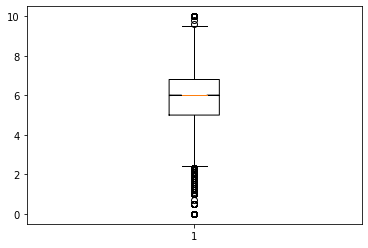

In [127]:
#Get rid of the outliers in vote_average column
plt.boxplot(df_movies_metadata_bronze.vote_average, notch=True)

In [134]:
#There are no outliers on the vote_average column
df_movies_metadata_bronze[(df_movies_metadata_bronze['vote_average'] < 0) | (df_movies_metadata_bronze['vote_average'] > 10)]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,overview_cleaned


{'whiskers': [<matplotlib.lines.Line2D at 0x7f911e4f8710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f911e4f8e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f911e4f8400>],
 'medians': [<matplotlib.lines.Line2D at 0x7f911e503550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f911e5038d0>],
 'means': []}

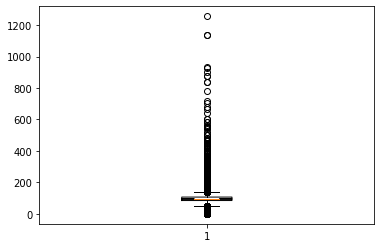

In [132]:
#Get rid of the outliers in runtime column
plt.boxplot(df_movies_metadata_bronze.runtime, notch=True)

Looking at the data I will be getting rid of the movies with runtime > 900 minutes(>15 hours) and lesser than 0

In [135]:
#Finding the outliers on the runtime column
df_movies_metadata_bronze[(df_movies_metadata_bronze['runtime'] < 0) | (df_movies_metadata_bronze['runtime'] > 900)]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,overview_cleaned
13767,0,"[{'id': 18, 'name': 'Drama'}]",45560,de,"Berlin Alexanderplatz, originally broadcast in 1980, is a 14-part television film adapted and directed by Rainer Werner Fassbinder from the Alfred Döblin novel of the same name, and stars Günter Lamprecht, Hanna Schygulla, Barbara Sukowa, Elisabeth Trissenaar and Gottfried John. The complete film is 15½ hours long.",2.255785,"[{'name': 'Bavaria Film', 'id': 1704}, {'name': 'Westdeutscher Rundfunk (WDR)', 'id': 7025}, {'name': 'RAI Radiotelevisione Italiana', 'id': 20091}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'IT', 'name': 'Italy'}]",1980-08-28,0,931,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,Berlin Alexanderplatz,8.4,5,berlin alexanderplatz originally broadcast part television film adapted directed rainer werner fassbinder alfred döblin novel name star günter lamprecht hanna schygulla barbara sukowa elisabeth trissenaar gottfried john complete film ½ hour long
13953,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name': 'History'}]",67463,de,"This epic tale of a family and their rural life in a small German village is told against the changing backdrop of a country's turbulent history from 1919 to 1982. From the aftermath of the First World War, economic hardship, the rise and fall of Nazism, the Second World War and the decades that followed, life in the village goes on and the values and aspirations of the people at its heart are wonderfully brought to life in this gripping saga of an ordinary family living through extraordinary times.",0.016204,[],"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1984-09-16,0,925,[],Released,Heimat: A Chronicle Of Germany,9.0,1,epic tale family rural life small german village told changing backdrop country turbulent history aftermath first world war economic hardship rise fall nazism second world war decade followed life village go value aspiration people heart wonderfully brought life gripping saga ordinary family living extraordinary time
19965,0,"[{'id': 99, 'name': 'Documentary'}]",142051,en,A survey of the musical form's history and major talents.,1.507756,[],[],2001-01-09,0,1140,[],Released,Jazz,5.7,3,survey musical form history major talent
24178,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name': 'History'}]",67493,en,The economic and cultural growth of Colorado spanning two centuries from the mid-1700s to the late-1970s.,0.664727,"[{'name': 'Universal Television', 'id': 26727}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1978-10-01,0,1256,[],Released,Centennial,7.9,8,economic cultural growth colorado spanning two century mids lates
40938,0,"[{'id': 99, 'name': 'Documentary'}]",126820,en,"Chronicles the sport's signature people, places and events as well as its deep-rooted relationship to American culture. The pastime's century-and-a-half history unfolds over ten nostalgic, informative ""innings"" which delve into baseball's spiritual resonance with the entire nation.",0.145073,[],[],1994-09-18,0,1140,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Baseball,8.5,4,chronicle sport signature people place event well deeprooted relationship american culture pastime centuryandahalf history unfolds ten nostalgic informative inning delve baseball spiritual resonance entire nation


In [136]:
#We will not be removing any popular movie having runtime as outlier
df_movies_metadata_bronze[((df_movies_metadata_bronze['runtime'] < 0) | (df_movies_metadata_bronze['runtime'] > 900)) & df_movies_metadata_bronze.popularity > 1]

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,overview_cleaned


In [138]:
# get names of indexes for which
# df_movies_metadata_bronze['runtime'] < 0 or df_movies_metadata_bronze['runtime'] > 900
index_names = df_movies_metadata_bronze[(df_movies_metadata_bronze['runtime'] < 0) | (df_movies_metadata_bronze['runtime'] > 900)].index

In [139]:
df_movies_metadata_bronze.shape

(44771, 17)

In [140]:
 # drop these row indexes
# from dataFrame
df_movies_metadata_bronze.drop(index_names, inplace = True)

In [141]:
df_movies_metadata_bronze.shape

(44766, 17)

### Put Data (Silver) <a class="anchor" id="PS"></a>
- Raw data extraction for the file, API based and web datasets. Let us call this __Bronze Layer__.
- Data transformation using python from Raw to Processed stage. We will call this __Silver Layer__.
- Finally store the processed data using standard taxonomy in a SQL based serving layer. We will call this __Gold Layer__.

#### Write the transformed dataframe to the silver zone <a class="anchor" id="WS"></a>

In [143]:
silver_file_name = silver_data_folder + "movies_metadata.csv"
df_movies_metadata_bronze.to_csv(silver_file_name, index=False)

#### Read silver zone movies file <a class="anchor" id="RS"></a>

In [144]:
df_movies_metadata_silver = pd.read_csv(silver_file_name)
df_movies_metadata_silver.head(3).transpose()

,0,1,2
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]","[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]","[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"
id,862,8844,15602
original_language,en,en,en
overview,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.","When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.","A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max."
popularity,21.9469,17.0155,11.7129
production_companies,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]"
production_countries,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]"
release_date,1995-10-30,1995-12-15,1995-12-22
revenue,373554033,262797249,0
